In [1]:
from pylab import *

In [2]:
def ReadConfigFile(filename):
    # This reads the Poisson simulator config file for
    # the settings that were run
    # and returns a dictionary with the values

    with open(filename,'r') as file:
        lines=file.readlines()
    lines = [ l.strip() for l in lines ]
    lines = [ l.split() for l in lines if len(l) > 0 and l[0] != '#' ]
    for line in lines:
        if line[1] != '=':
            print("Check line: ",line)
            raise IOError("Error reading config file %s"%filename)
    config = {}
    for line in lines:
        try:
            # First get the ordered pairs
            config.update({line[0]:[eval(line[2]), eval(line[3])]})
        except:
            try:
                # Then get the numeric values
                config.update({line[0]:eval(line[2])})
            except:
                try:
                    # Last, get the strings
                    config.update({line[0]:str(line[2])})
                except:
                    pass
    return config


In [3]:
Vbb = array([-15.7,-22.5,-35.0,-50.0,-70.0]) # These are the appied Vbb voltages from Sergey's presentation
Vplot = linspace(-15.0,-75.0,100)
Diff = [6.25,5.11,4.51,4.06,3.41] # Measured these off Sergey's plot 
Model = 28.0 * sqrt(-1.0/Vplot)

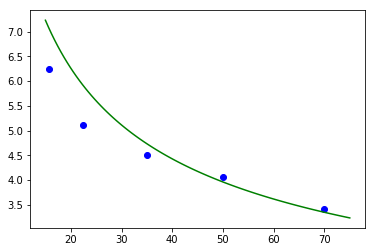

In [4]:
# First, just plot vs sqrt(1/Vbb).  Not a very good fit

plot(-Vplot, Model, color = 'green')
scatter(-Vbb, Diff, marker = 'o', color = 'blue')
show()

In [15]:
# Let's refine the model for use in GalSim
# We should have Sigma = Sqrt(Tsi*(TSi-ConversionDepth)*kT/(q*Vapplied)/MobilityFactor)
# Key is calculating the average front side voltage
# We'll do this by looking at the simulated voltage about 1 micron above the bottom:
# Channel stop region: V ~ 0.0V
# Collect Gate: V ~ Vph + 12.0V
# Barrier Gate: V ~ Vpl + 15.0V

# Next, read the .cfg file to get the values
configfile = "/Users/cslage/Research/LSST/code/galsim-24apr18/GalSim/share/sensors/lsst_itl_32.cfg"
ConfigData = ReadConfigFile(configfile)
PixelSize = ConfigData["PixelSizeX"]
SensorThickness = ConfigData["SensorThickness"]
ChannelStopWidth = ConfigData["ChannelStopWidth"]
FieldOxideTaper = ConfigData["FieldOxideTaper"]
Vparallel_hi = ConfigData["Vparallel_hi"]
Vparallel_lo = ConfigData["Vparallel_lo"]
qfh = ConfigData["qfh"]
NumPhases = ConfigData["NumPhases"]
CollectingPhases = ConfigData["CollectingPhases"]
CCDTemperature = ConfigData["CCDTemperature"]

VChannelStop = qfh # near zero
VCollect = Vparallel_hi + 12.0 # Estimate from simulation
VBarrier = Vparallel_lo + 15.0 # Estimate from simulation

ChannelStopRegionWidth = 2.0 * (ChannelStopWidth / 2.0 + FieldOxideTaper)
ChannelStopRegionArea = ChannelStopRegionWidth * PixelSize
CollectArea = (PixelSize - ChannelStopRegionWidth) * PixelSize * CollectingPhases / NumPhases 
BarrierArea = (PixelSize - ChannelStopRegionWidth) * PixelSize * (NumPhases - CollectingPhases) / NumPhases 
Vfront = (ChannelStopRegionArea * VChannelStop + CollectArea * VCollect + BarrierArea * VBarrier) / (PixelSize**2)
print("Average Frontside voltage = %.2f Volts"%Vfront)

MobilityFactor = 0.27 # This is the factor from Green et.al.
ConversionDepth = 20.0 # Approximate average conversion depth
kTq = 0.026 * CCDTemperature / 298.0 # This is the value of kT/q in Volts at the CCD temperature
NewModel = sqrt(SensorThickness * (SensorThickness - ConversionDepth) * 2.0 * kTq / (Vfront - Vplot) / MobilityFactor)


Average Frontside voltage = 7.80 Volts


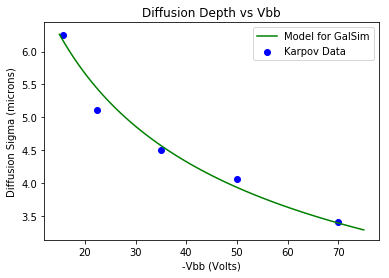

In [16]:
figure()
title("Diffusion Depth vs Vbb")
plot(-Vplot, NewModel, color = 'green', label = "Model for GalSim")
scatter(-Vbb, Diff, marker = 'o', color = 'blue', label="Karpov Data")
xlabel("-Vbb (Volts)")
ylabel("Diffusion Sigma (microns)")
legend()
#show()
savefig("/Users/cslage/Research/LSST/code/poisson/Poisson_CCD_Hole20_Fe55/Diffusion_Model_07Aug18.png")